In [2]:
import frgtools.misc as frgm
import frgtools.plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from matplotlib import style
mpl.rcParams.update(mpl.rcParamsDefault)

import matplotlib.colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from apstools import s2, xrf
import frgtools.plotting as frgplt
import mendeleev as men

In [3]:
fids = []
for f in frgm.listdir('/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis', display = False):
    if '.txt' in f and '.tif' not in f:
        continue
    fids.append(f)

In [4]:
os.path.basename(fids[0]).split('.')[0]

'Scan3_defect'

In [5]:
fids[0].split('.')

['/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan3_defect',
 'psmsa']

In [6]:
fids
# len(fids)

['/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan3_defect.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan3_film.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan3_pinhole.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan4_defect.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan4_film.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan4_hole.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan5_defect.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Apreo/20210323_T9c/EDX/edx_analysis/Scan5_film.psmsa',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/SEM_Ap

In [7]:
def load_apreoEDX(fpath):

    RAS_HEADER_START = "#FORMAT      : EMSA/MAS Spectral Data File"
    RAS_HEADER_END   = "#COMMENT     : The following parameters are defined by Thermo Fisher Scientific"
    RAS_INT_START    = "#SPECTRUM    :"
    RAS_INT_END      = "#ENDOFDATA   :"
    HEADER_SPLIT     = "\""
    DATA_SPLIT       = ","
    
    data = {}
    internal = {}
    data['name'] = os.path.basename(fpath).split('.')[0] #remove .ras
    data['header'] = dict()
    data['counts'] = []
#     internal['MEAS_COND_AXIS_NAME'] = dict() #Array
#     internal['MEAS_COND_AXIS_NAME_INTERNAL'] = dict() #Array
#     internal['MEAS_COND_AXIS_OFFSET'] = dict() #Array
#     internal['MEAS_COND_AXIS_POSITION'] = dict() #Array
#     internal['MEAS_COND_AXIS_UNIT'] = dict() #Once
    
    data['acclV'] = ""
#     internal['acclV'] = ""
    data['angles'] = []
    data['numscans'] = 0
    internal['points_per_scan'] = 0

    with open(fpath, encoding="Latin-1", mode="r") as f:
        scan_start   = False
        scan_end     = False
        header_start = False
        scan_data    = []
        scan_angle   = []
        header_initialized = False
        scan_is_3d = False

        for line in f:
            if line.strip():
                line = line.strip()

#                 if line.startswith(RAS_HEADER_START):
#                     header_start = True
#                     # print(line)
#                     continue
#                 if line.startswith(RAS_HEADER_END):
#                     header_start = False
#                     header_initialized = True
#                     # print(line)
#                     continue
                if line.startswith(RAS_INT_START):
                    scan_start = True
                    continue
                if line.startswith(RAS_INT_END):
                    scan_start = False
                    pad_points = internal['points_per_scan'] - len(scan_data)
                    if pad_points > 0:
                        print("Data not complete. Number of data point missing for this scan: ", pad_points)
                        pad_data   = [0]*pad_points
                        scan_data.extend(pad_data)
                    data['angles'] = scan_angle
                    data['counts'].append(scan_data)
                    data['numscans'] +=1
                    scan_data = []
                    scan_angle= []
                    # continue
                    
                if scan_start:
                    ls = line.split(DATA_SPLIT)
                    # print(ls)
                elif header_start:
                    ls = line.split(HEADER_SPLIT)
                else:
                    continue
                    
                    
                if header_start:
                    key = ls[0][1:].strip()
                    val = ls[1].strip()
                    if not header_initialized: #If the header is read for the first time, we need to fill different metadata information (basically all)
                        data['header'][key] = val #We collect all metadata in the header - done only Once.
                        if "MEAS_COND_AXIS_NAME-" in key:
                            tmp = key.split("-")
                            order = int(tmp[1].strip())
                            internal['MEAS_COND_AXIS_NAME'][order] = val
                            
                        if "MEAS_COND_AXIS_NAME_INTERNAL-" in key:
                            tmp = key.split("-")
                            order = int(tmp[1].strip())
                            internal['MEAS_COND_AXIS_NAME_INTERNAL'][order] = val
                            
                            
                            
                            
                            
                        if "MEAS_COND_AXIS_OFFSET-" in key:
                            tmp = key.split("-")
                            order = int(tmp[1].strip())
                            try:
                                val = float(val)
                            except:
                                val = 0
                            internal['MEAS_COND_AXIS_OFFSET'][order] = val
                        if "MEAS_COND_AXIS_POSITION-" in key:
                            tmp = key.split("-")
                            order = int(tmp[1].strip())
                            try:
                                val = float(val)
                                internal['MEAS_COND_AXIS_POSITION'][order] = [val]
                            except:
                                internal['MEAS_COND_AXIS_POSITION'][order] = val
                        if "MEAS_COND_AXIS_UNIT-" in key:
                            tmp = key.split("-")
                            order = int(tmp[1].strip())
                            internal['MEAS_COND_AXIS_UNIT'][order] = val
                        if "MEAS_DATA_COUNT" in key:
                            internal['points_per_scan'] = int(float(val))
#                         if key == "MEAS_SCAN_AXIS_X":
#                             data['scanaxis'] = val
                        if key == "MEAS_SCAN_AXIS_X_INTERNAL":
                            internal['scan_axis_internal'] = val
                        if key == "MEAS_SCAN_START":
                            internal['scan_angle_start'] = float(val)
                        
                        
#                         if "BEAMKV" in key:
                        if key == "BEAMKV":
                            
                            data['acclV'] = float(val)

                            
#                         if key == "BEAMKV":
#                             order = int(tmp[1].strip())
#                             internal['MEAS_COND_AXIS_NAME'][order] = val
                            
                            
                        if key == "MEAS_SCAN_STOP":
                            internal['scan_angle_stop'] = float(val)
                    
                    
                        if key == "MEAS_SCAN_START_TIME":
                            data['date'], data['time'] = val.split(' ')
                        if key == "MEAS_SCAN_MODE":
                            data['scanmode'] = val
                        if key == "MEAS_SCAN_SPEED":
                            data['scanspeed'] = float(val)
                            
                            
                        if key == "MEAS_3DE_STEP_AXIS_INTERNAL":
                            scan_is_3d = True
                            internal['MEAS_3DE_STEP_AXIS_INTERNAL'] = val.strip()

                            
#                     else: #Header already initialized, we add new position to the axis, if they are number and not string.
#                         if "MEAS_COND_AXIS_POSITION-" in key:
#                             tmp = key.split("-")
#                             order = int(tmp[1].strip())
#                             try:
#                                 val = float(val)
#                                 internal['MEAS_COND_AXIS_POSITION'][order].append(val)
#                             except:
#                                 continue
                                    
                if scan_start:
                    a = float(ls[0].strip())
                    v = float(ls[1].strip())
                    scan_angle.append(a)
                    scan_data.append(v)
                    # print("Angle {:.2f} Intensity: {:.2f}".format(a,v))
                
        data['counts'] = np.asarray(data['counts'])
        if data['numscans'] == 1:
            data['counts'] = data['counts'][0]
            
        # data['angles'] = np.linspace(internal['scan_angle_start'], internal['scan_angle_stop'], internal['points_per_scan'])

#         if scan_is_3d:
#             for k, v in internal['MEAS_COND_AXIS_NAME'].items():
#                 if v == internal['MEAS_3DE_STEP_AXIS_INTERNAL']:
#                     axis2_idx = k
#                     data['angles2'] = internal['MEAS_COND_AXIS_POSITION'][axis2_idx]


        return data

In [8]:
dfData = {}

for idx, f in enumerate(fids):
    tempdata = load_apreoEDX(f)
    del(tempdata['header']) #assumes we dont need the header for following analyses
                            # some tool parameters in here are important to keep track of ie step size, and res
                            # will make repeating sucessful scans easy
    
    if idx == 0: #on first pass, initialize keys for each data entry in the dataframe dictionary
        for k, v in tempdata.items():
            dfData[k] = [v]
    else:  #on subsequent passes, append new lines of data to dataframe dictionary
        for k, v in tempdata.items():
            dfData[k].append(v)      

df = pd.DataFrame(dfData)

In [9]:
def normalizeCounts(x):
    return (x-x.min()) / (x.max() - x.min())

In [42]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = ''
Filter_2 = ''
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
for n in df_filter3['name'].unique(): print(n)

Scan3_defect
Scan3_film
Scan3_pinhole
Scan4_defect
Scan4_film
Scan4_hole
Scan5_defect
Scan5_film
Scan6_film2
Scan6_defect
Scan6_film1


In [43]:
df_filter3['counts_norm'] = np.array
for n in range(df_filter3.shape[0]):
    df_filter3['counts_norm'][n] = normalizeCounts(df_filter3['counts'][n]) 

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
from functools import partial #https://docs.python.org/2/library/functools.html
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
#savgol_filter to smooth the data

# df['counts_f1'] = df['counts_norm'].apply(
df_filter3['counts_f1'] = df_filter3['counts_norm'].apply(
    partial(savgol_filter, window_length = 5, polyorder = 3)
)

In [45]:
df_filter3 = df_filter3.sort_values(by=['name'])
df_filter3 = df_filter3.reset_index(drop=True)
df_filter3

,name,counts,acclV,angles,numscans,counts_norm,counts_f1
0,Scan3_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Scan3_film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Scan3_pinhole,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Scan4_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Scan4_film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,Scan4_hole,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,Scan5_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Scan5_film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Scan6_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Scan6_film1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


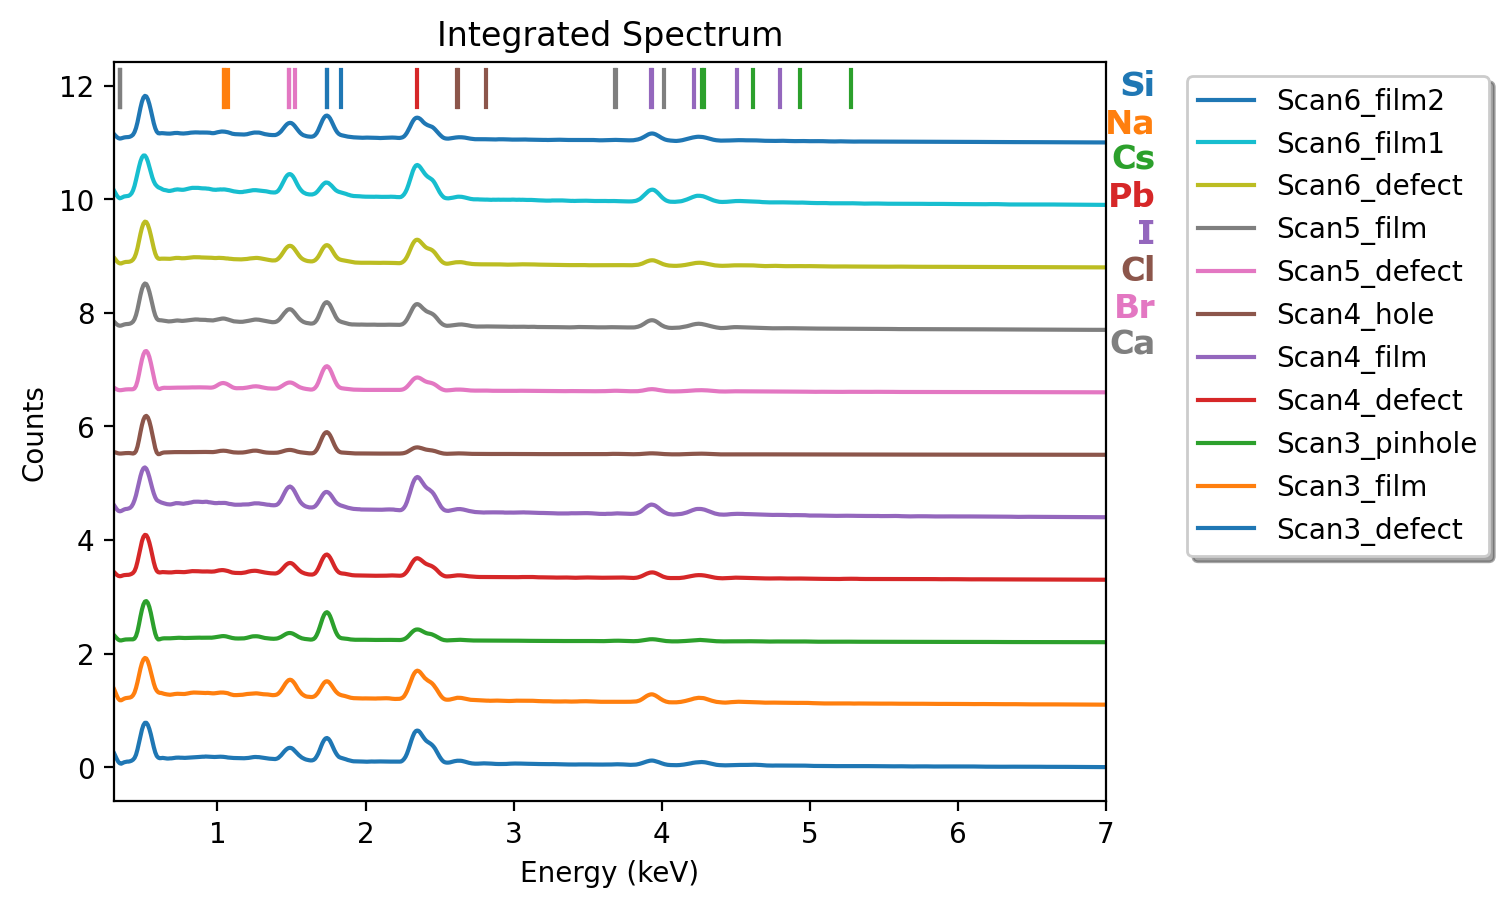

In [63]:
# filtered DataFrame to Plot
DF = df_filter3

# single
# q = 3
# plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts'], label=DF['name'][q])

# multiple:
fig = plt.figure()
ax = fig.add_subplot()

for q, (_, r) in enumerate(DF.iterrows()):
    #mask out low intensity peaks
#     a = r['peak_intensity']
#     a = np.ma.masked_where(a <= min_intensity, a)
    
    #plotting
    plt.plot(r['angles'], r['counts_f1'] + q*1.1, label = r['name'])#+' '+r['condition'])#, label='CsPbI.8Br.1Cl.1' )#label = r['name'])
#     plt.plot(r['peak_angle'], a + 0.07 + q*1.1, '+')


# for q in range (len(DF)):
#     plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts_norm'], label=DF['name'][q])

plt.legend()
# plt.ylim(.3,7)
plt.xlim(.3,7)
# plt.yscale("log")


handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper right', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)

plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Integrated Spectrum')


xrf.plot_XRF_lines(
    ['Si', 'Na', 'Cs', 'Pb', 'I', 'Cl', 'Br', 'Ca'],
    tickloc = 'top',
    tickstagger = 0 #usually only need 0.01-0.05 here if lines are really overlapping
)


plt.show()

In [47]:
from functools import partial #https://docs.python.org/2/library/functools.html
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
#savgol_filter to smooth the data

# df['counts_f1'] = df['counts_norm'].apply(
df_filter3['counts_f1'] = df_filter3['counts_norm'].apply(
    partial(savgol_filter, window_length = 15, polyorder = 3)
)

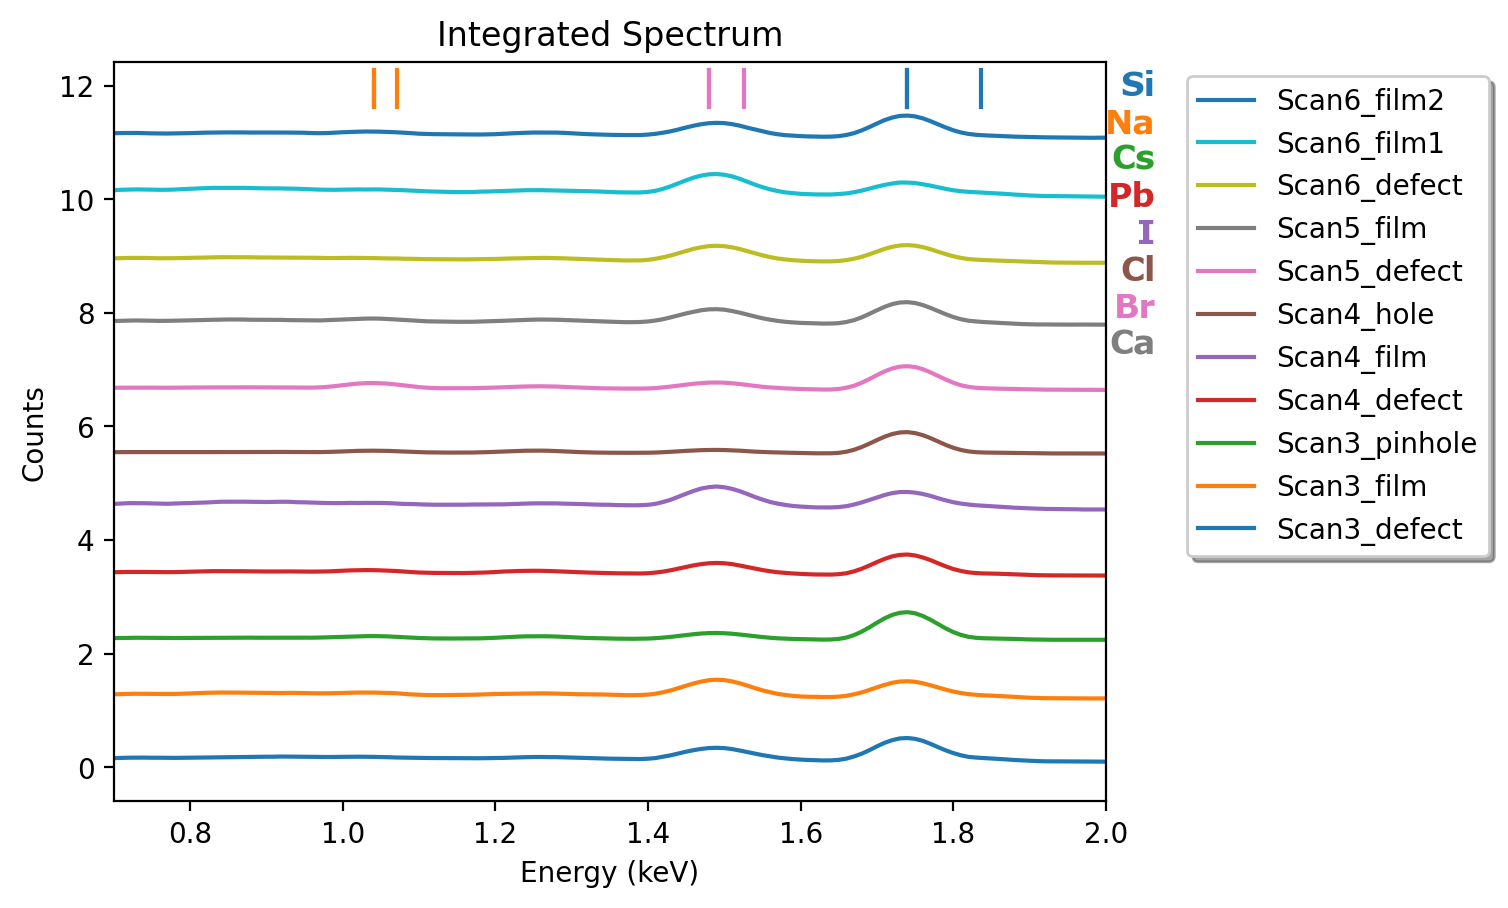

In [67]:
# filtered DataFrame to Plot
DF = df_filter3

# single
# q = 3
# plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts'], label=DF['name'][q])

# multiple:
fig = plt.figure()
ax = fig.add_subplot()

for q, (_, r) in enumerate(DF.iterrows()):
    #mask out low intensity peaks
#     a = r['peak_intensity']
#     a = np.ma.masked_where(a <= min_intensity, a)
    
    #plotting
    plt.plot(r['angles'], r['counts_f1'] + q*1.1, label = r['name'])#+' '+r['condition'])#, label='CsPbI.8Br.1Cl.1' )#label = r['name'])
#     plt.plot(r['peak_angle'], a + 0.07 + q*1.1, '+')


# for q in range (len(DF)):
#     plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts_norm'], label=DF['name'][q])

plt.legend()
# plt.ylim(.3,7)
plt.xlim(.7,2)
# plt.yscale("log")


handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper right', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)

plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Integrated Spectrum')


xrf.plot_XRF_lines(
    ['Si', 'Na', 'Cs', 'Pb', 'I', 'Cl', 'Br', 'Ca'],
    tickloc = 'top',
    tickstagger = 0 #usually only need 0.01-0.05 here if lines are really overlapping
)


plt.show()

In [49]:
DF

,name,counts,acclV,angles,numscans,counts_norm,counts_f1
0,Scan3_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Scan3_film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Scan3_pinhole,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Scan4_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Scan4_film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,Scan4_hole,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,Scan5_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Scan5_film,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Scan6_defect,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Scan6_film1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


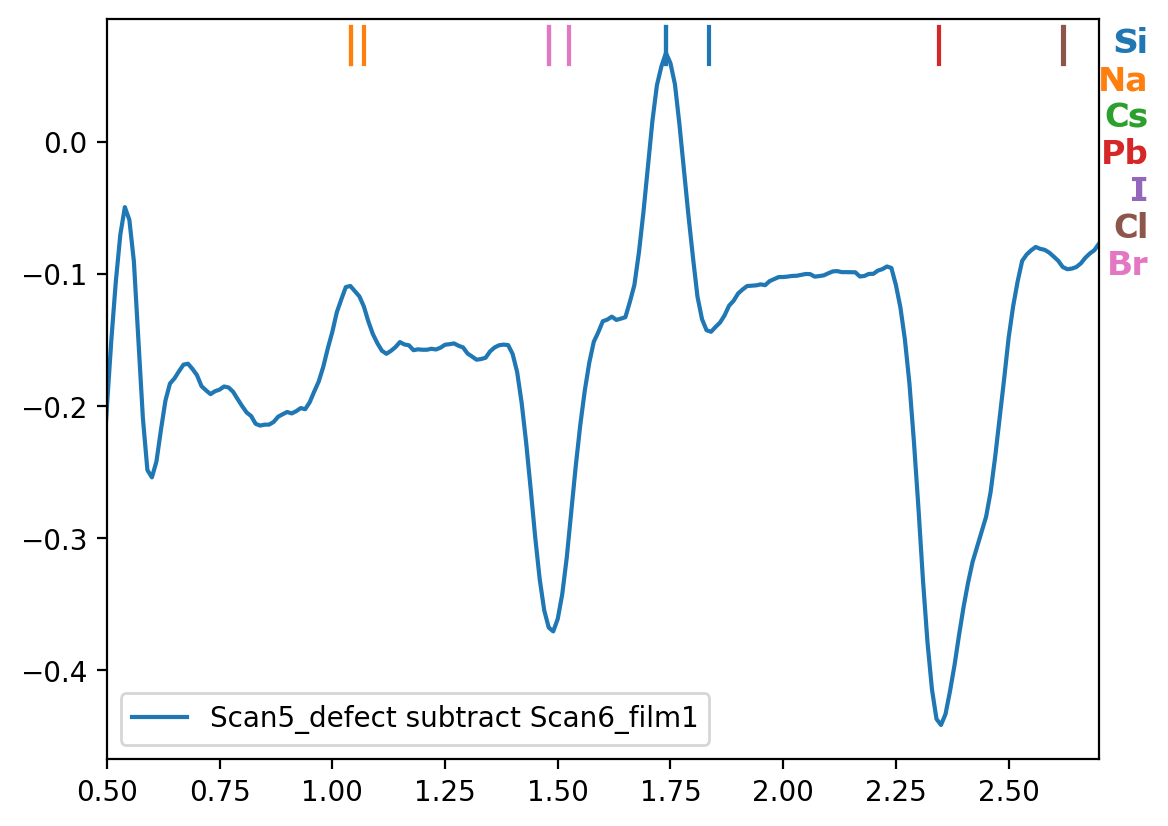

In [61]:
plt.plot(DF['angles'][0], (DF['counts_f1'][6]-DF['counts_f1'][9])*1, label = (DF['name'][6]+' subtract '+DF['name'][9])) 
plt.legend()
xrf.plot_XRF_lines(
    ['Si', 'Na', 'Cs', 'Pb', 'I', 'Cl', 'Br'],
    tickloc = 'top',
    tickstagger = 0 #usually only need 0.01-0.05 here if lines are really overlapping
)

plt.xlim(.5,2.7)

plt.show()

In [506]:
xrf.emissionLines['Na']


{'zNum': 11, 'xrfEmissionLines': [1.04098, 1.04098, 1.0711]}

# plt.plot(d['angles'], d['counts'])
plt.xlim(.3,7)
# plt.yscale('log')
# plt.ylim(bottom = 1e4)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Integrated Spectrum')

# adding element ticks
xrf.plot_XRF_lines(
    ['Si', 'Na', 'Cs', 'Pb', 'I', 'Cl', 'Br'],
    tickloc = 'bottom',
    tickstagger = 0 #usually only need 0.01-0.05 here if lines are really overlapping
)
plt.show()